In [ ]:
!pip install --upgrade gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#general imports
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np # linear algebra
import seaborn as sns # plotting
import matplotlib.pyplot as plt # plotting
%matplotlib inline
import os # accessing directory structure
import torch
import sqlite3
import re


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import warnings

#NLP processing imports
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from nltk.tokenize import RegexpTokenizer
!pip install stop-words
from stop_words import get_stop_words
import re
import spacy

###Vader Sentiment
#To install vaderSentiment
!pip install vaderSentiment 
from vaderSentiment import vaderSentiment
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

####Lemmatization
from nltk.stem import WordNetLemmatizer
# Lemmatize with POS Tag
from nltk.corpus import wordnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#DATA

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
!gdown 1ncdP1AApEkXYD8ZoU_VkPw8x_K6buiiE
!gdown 1ghIDtwv6UD1tJciYxYdcN7zhxR_6RK70

Downloading...
From: https://drive.google.com/uc?id=1ncdP1AApEkXYD8ZoU_VkPw8x_K6buiiE
To: /content/flipkart_products.db
100% 8.59M/8.59M [00:00<00:00, 103MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ghIDtwv6UD1tJciYxYdcN7zhxR_6RK70
To: /content/Sample_Reviews.csv
100% 2.18k/2.18k [00:00<00:00, 8.53MB/s]


In [ ]:
import sqlite3

# Read sqlite query results into a pandas DataFrame
con = sqlite3.connect("./flipkart_products.db")
items = pd.read_sql_query("SELECT * from items", con)
con.close()

In [ ]:
items.head()


,product_id,product_name,price,category,sub_category,specifications,ratings,discount,moreinfo
0,ECMB000001,"Redmi 9A (SeaBlue, 32 GB)","₹7,413",Electronics,Mobile,2 GB RAM | 32 GB ROM16.59 cm (6.53 inch) Full ...,4.3,3.0,/redmi-9a-seablue-32-gb/p/itmeabd39a0cd669?pid...
1,ECMB000002,"Redmi 9A (Midnight Black, 32 GB)","₹7,421",Electronics,Mobile,2 GB RAM | 32 GB ROM16.59 cm (6.53 inch) Full ...,4.3,3.0,/redmi-9a-midnight-black-32-gb/p/itmeabd39a0cd...
2,ECMB000003,"Redmi 9A (Nature Green, 32 GB)","₹7,384",Electronics,Mobile,2 GB RAM | 32 GB ROM16.59 cm (6.53 inch) Full ...,4.3,4.0,/redmi-9a-nature-green-32-gb/p/itmeabd39a0cd66...
3,ECMB000004,"Redmi 9 (Carbon Black, 64 GB)","₹10,745",Electronics,Mobile,4 GB RAM | 64 GB ROM16.59 cm (6.53 inch) HD+ D...,4.2,None,/redmi-9-carbon-black-64-gb/p/itm4fb151383983b...
4,ECMB000005,"Redmi 9 (Sky Blue, 64 GB)","₹10,489",Electronics,Mobile,4 GB RAM | 64 GB ROM16.59 cm (6.53 inch) HD+ D...,4.2,None,/redmi-9-sky-blue-64-gb/p/itm4fb151383983b?pid...


In [ ]:
# Create Dataframe from DB
con = sqlite3.connect("./flipkart_products.db")

df = pd.read_sql_query("SELECT * from ECMB000001", con)

for i in range(2, len(items) + 1):

    df_temp = pd.read_sql_query("SELECT * from ECMB{:06d}".format(i), con)
    df = pd.concat([df, df_temp])
con.close()


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53493 entries, 0 to 289
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   product_id  53493 non-null  object
 1   review_id   53493 non-null  object
 2   title       53493 non-null  object
 3   review      53493 non-null  object
 4   likes       53493 non-null  object
 5   dislikes    53493 non-null  object
 6   ratings     48488 non-null  object
 7   reviewer    53493 non-null  object
dtypes: object(8)
memory usage: 3.7+ MB


In [ ]:
df.head()

,product_id,review_id,title,review,likes,dislikes,ratings,reviewer
0,ECMB000001,ECMB0000010000001,Excellent,Wow superb I love it❤️👍 battery backup so nice 👍👍,740,160,5,Abhishek Saini
1,ECMB000001,ECMB0000010000002,Worth the money,Mobile So Good In Range Redmi 9a Has Miui 12 L...,355,104,4,Dinesh Kumar Sahni
2,ECMB000001,ECMB0000010000003,Just wow!,Wonderful device and smart phone best camera b...,125,47,5,Flipkart Customer
3,ECMB000001,ECMB0000010000004,Simply awesome,Very good mobile. Value for money. Battery bac...,0,0,5,Amit Sen
4,ECMB000001,ECMB0000010000005,Highly recommended,Really great.... value for money...,90,15,5,Sudeshna pakira


### Handle Missing Values

<Figure size 2500x2000 with 0 Axes>

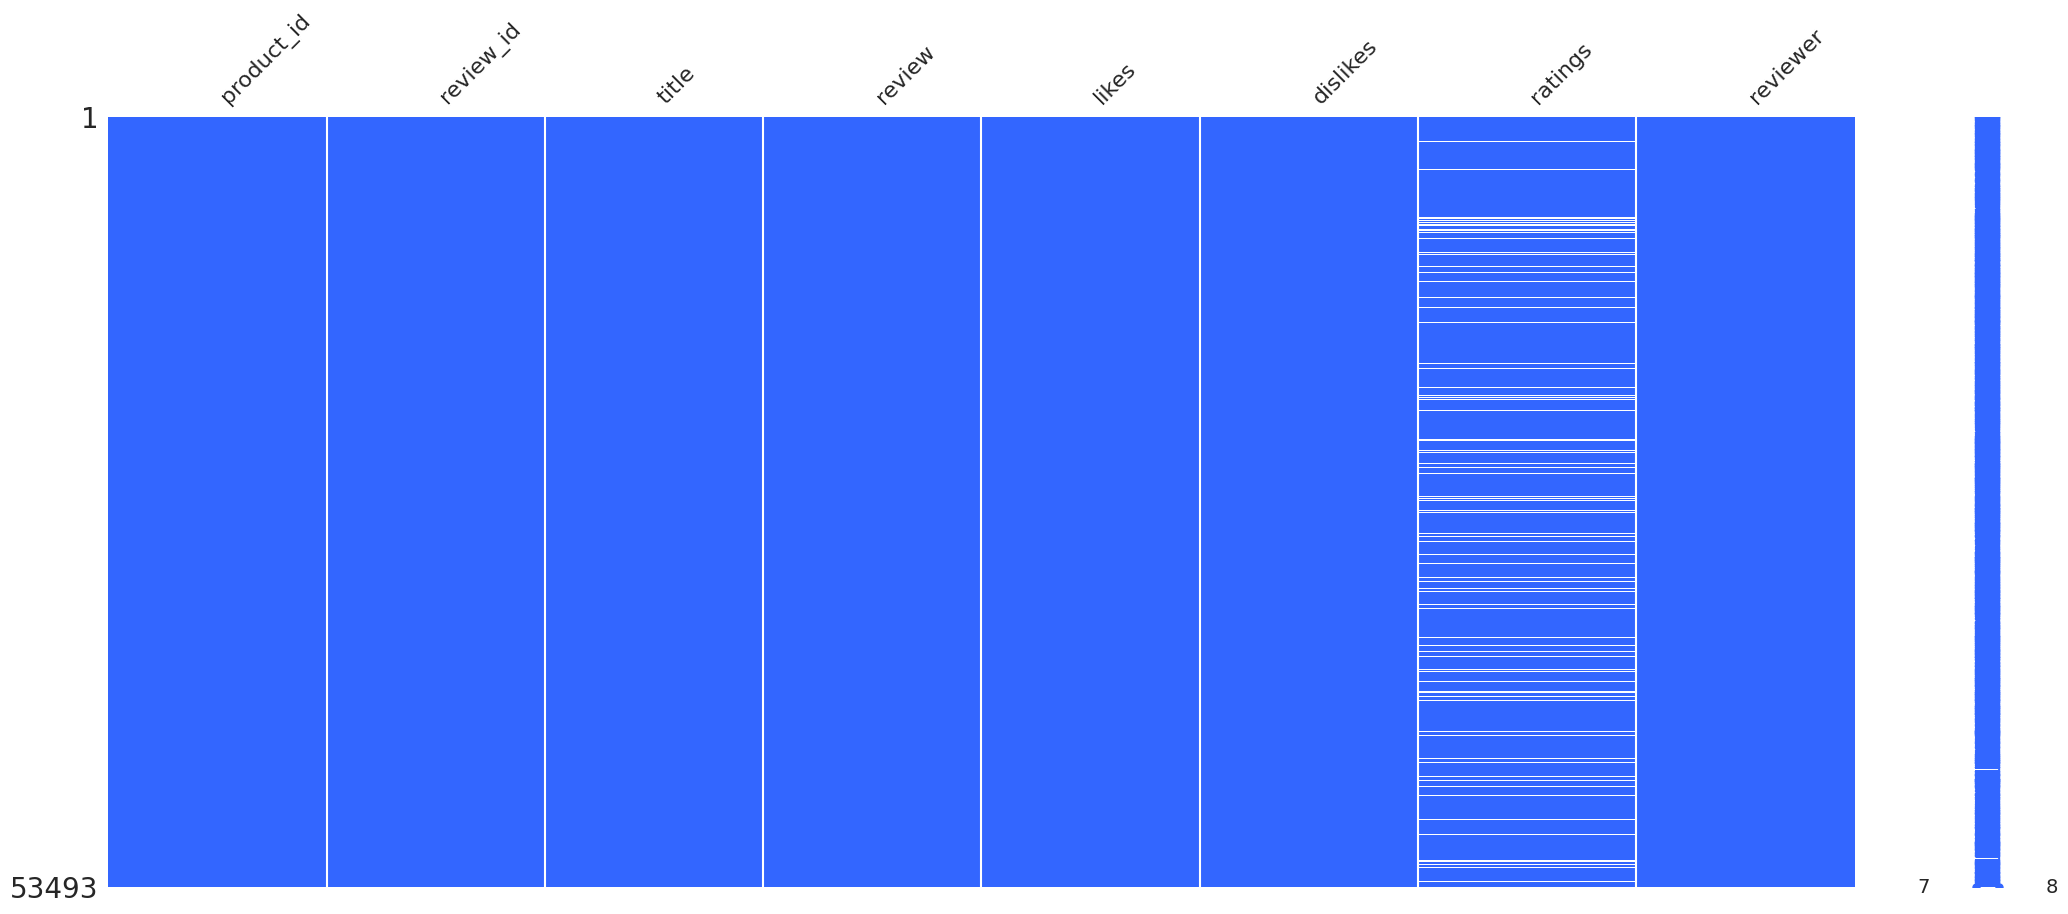

In [ ]:
import missingno as msno
plt.figure(figsize=(25, 20))
msno.matrix(df, color=[0.2, 0.4, 1])
plt.show()

In [ ]:
df.dropna(inplace=True, axis=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48488 entries, 0 to 287
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   product_id  48488 non-null  object
 1   review_id   48488 non-null  object
 2   title       48488 non-null  object
 3   review      48488 non-null  object
 4   likes       48488 non-null  object
 5   dislikes    48488 non-null  object
 6   ratings     48488 non-null  object
 7   reviewer    48488 non-null  object
dtypes: object(8)
memory usage: 3.3+ MB


<Figure size 2500x2000 with 0 Axes>

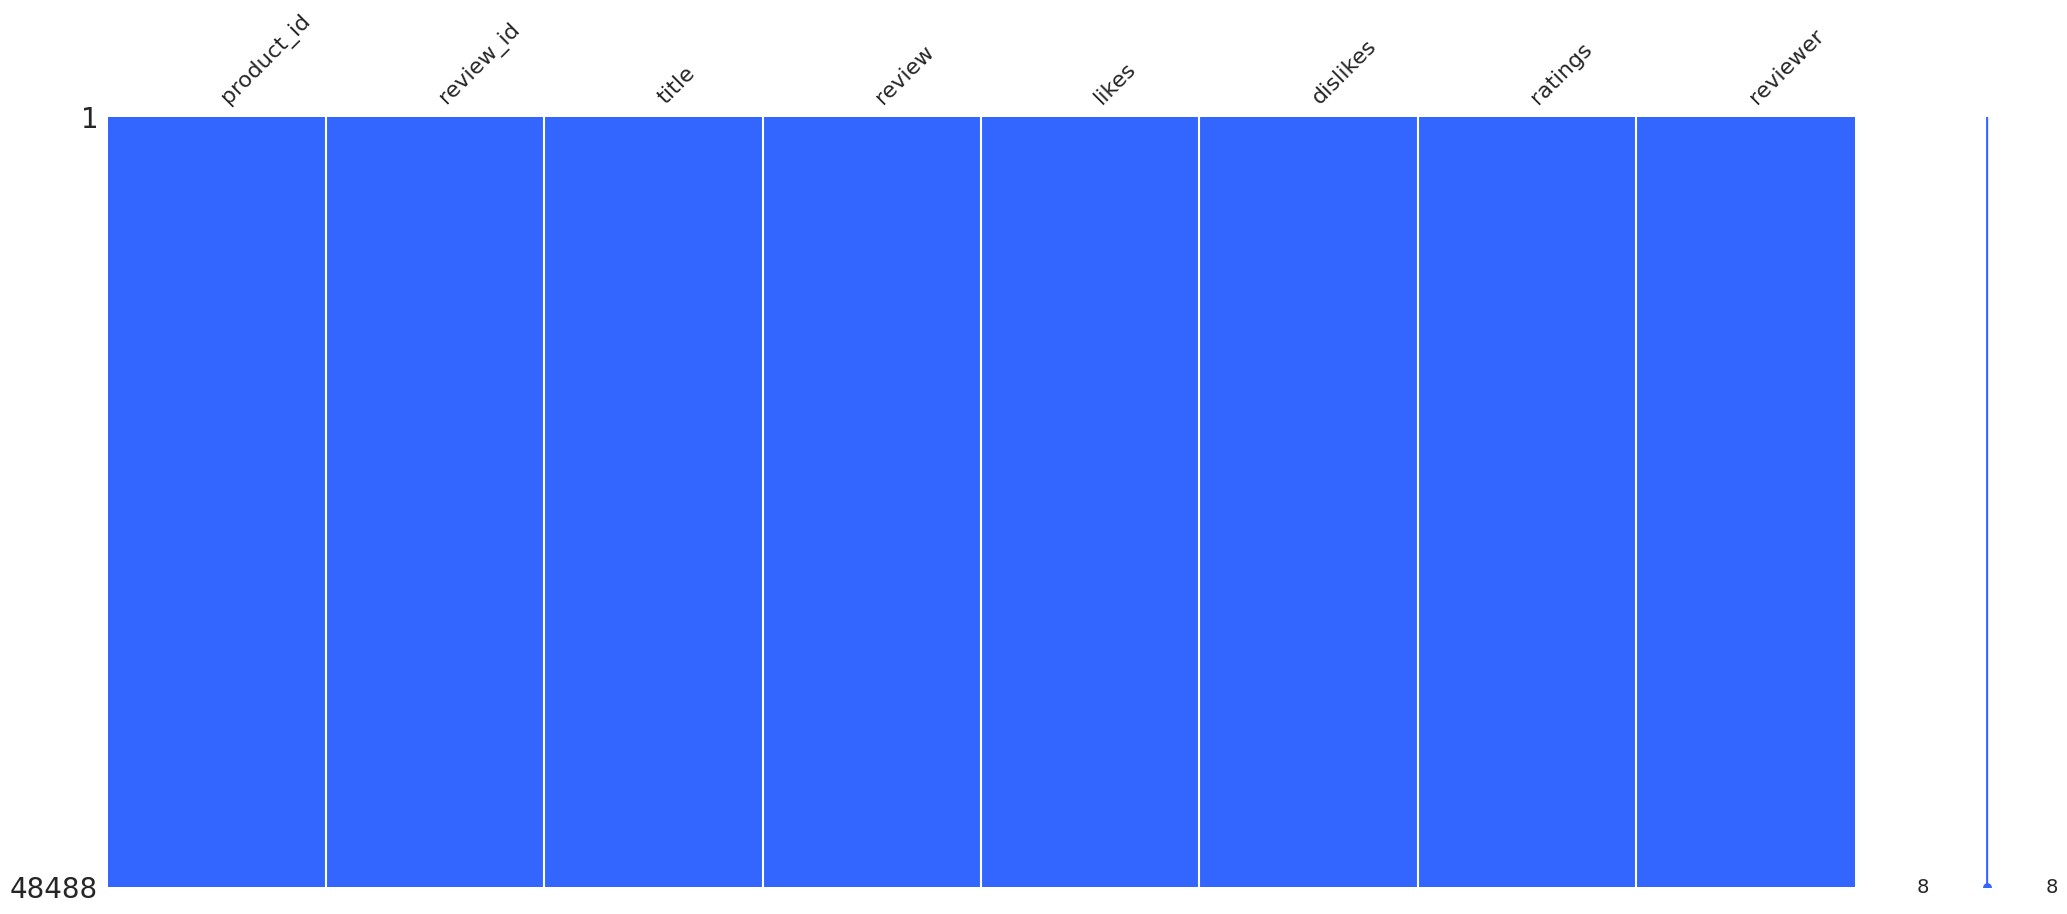

In [ ]:
import missingno as msno
plt.figure(figsize=(25, 20))
msno.matrix(df, color=[0.2, 0.4, 1])
plt.show()

In [ ]:
# Download necessary packages for NLTK

from nltk.corpus import stopwords

import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

en_stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#Augmentation

This will generate sample negative data by processing positive data 



In [ ]:
df_temp = df.copy()

# Assigning labels to each review

def label(y):
    if y == '5':
        return 1
    elif y == '4':
        return 1
    else:
        return 0
    
from tqdm import tqdm

tqdm.pandas()

df_temp['y'] = df_temp.ratings.progress_map(label)

100%|██████████| 48488/48488 [00:00<00:00, 774626.01it/s]


In [ ]:
df_temp = df_temp[['review', 'y', 'ratings']]

In [ ]:
df_temp.head()

,review,y,ratings
0,Wow superb I love it❤️👍 battery backup so nice 👍👍,1,5
1,Mobile So Good In Range Redmi 9a Has Miui 12 L...,1,4
2,Wonderful device and smart phone best camera b...,1,5
3,Very good mobile. Value for money. Battery bac...,1,5
4,Really great.... value for money...,1,5


In [ ]:
df_temp.y.value_counts()

1    44751
0     3737
Name: y, dtype: int64

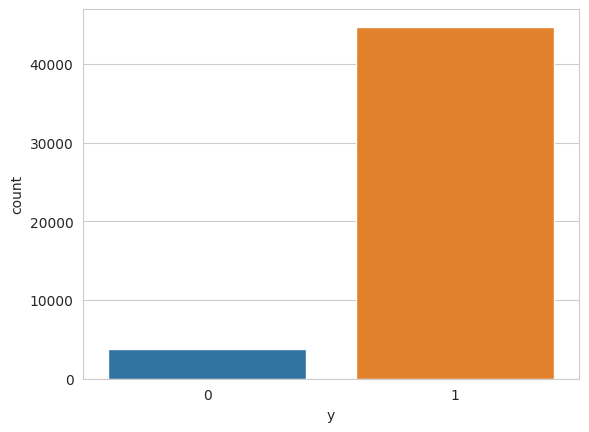

In [ ]:
import seaborn as sns

sns.countplot(x = "y", data = df_temp)
plt.show()

In [ ]:
df_temp2 = df_temp[(df_temp['ratings'] == '5')]

In [ ]:
positive = list(df_temp2[(df_temp2['review'].str.len() > 100) & (df_temp2['review'].str.len() < 350)]['review'])
len(positive)

4803

In [ ]:
!pip install nlpaug

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import nlpaug.augmenter.word as naw

In [ ]:
positive[41:49]

["An amazing smartphone for the price though i didn't like the colors compared to a realme phone in the same price range. It's a reall good second smartphone if you already have a primary device.",
 "Nice product according to its budget. But it's hard to play high Graphics games like pubg on 3GB RAM. It lags even when you play at Smooth Graphics settings. If this is for gaming (High graphics game) purpose, then don't go for 3GB or 2 GB RAM and the rest it works very well.",
 'I gave this phone to my wife as a gift and she loved it so much that she gets great performance and photos of games',
 'Every thing is great about the phone but a micro USB connector with a 5000 mah battery kind of suck a type c connector would have been better',
 'Very good handset at this price. Nice and great performance. Battery backup is also trustworthy. There is no issue till date after using for a period of 5days. Overall u can buy this phone without hesitation',
 'I am happy with your productus policy of 

In [ ]:
aug = naw.AntonymAug(name='Antonym_Aug', aug_min=1, aug_max=10, aug_p=0.3, lang='eng', stopwords=en_stopwords, tokenizer=None, 
                     reverse_tokenizer=None, stopwords_regex=None, verbose=0)
 
aug_negative = aug.augment(positive)

In [ ]:
len(aug_negative)

4803

In [ ]:
aug_negative[41:49]

["An amazing smartphone for the price though i didn ' t like the colors compared to a realme phone in the same price range. It ' s a reall bad second smartphone if you already have a secondary device.",
 "Nice product according to its budget. But it ' s hard to play low Graphics games like pubg on 3GB RAM. It lags even when you play at Smooth Graphics settings. If this is for gaming (Low graphics game) purpose, then don ' t malfunction for 3GB or 2 GB RAM and the rest it malfunction very disadvantageously.",
 'I starve this phone to my wife as a gift and she hate it so little that she leave great performance and photos of games',
 'Every thing is great about the phone but a micro USB connector with a 5000 mah battery kind of suck a type c connector would have been worse',
 'Very evil handset at this price. Nice and great performance. Battery backup is also untrustworthy. There is no issue till date after using for a period of 5days. Overall u can sell this phone without hesitation',
 '

In [ ]:
df_negative = pd.DataFrame({"review" : aug_negative, 'y' : [0]*len(aug_negative)})

In [ ]:
df_positive = pd.DataFrame({"review" : positive, 'y' : [1]*len(positive)})

In [ ]:
df_temp = pd.concat([df_negative, df_positive]).sample(frac = 1, random_state = 11).reset_index(drop=True)

In [ ]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9606 entries, 0 to 9605
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  9606 non-null   object
 1   y       9606 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 150.2+ KB


In [ ]:
df_temp.head()

,review,y
0,great phone in budget. .. pubg performance was...,0
1,Best Smartphone by Mi in this Range. . be born...,0
2,Bad smooth phone. . and back camera quality is...,0
3,Thise is very nice mobile ...I like it very mu...,1
4,I m meagerly dissatisfy 👍 All section r superb...,0


In [ ]:
df = df_temp

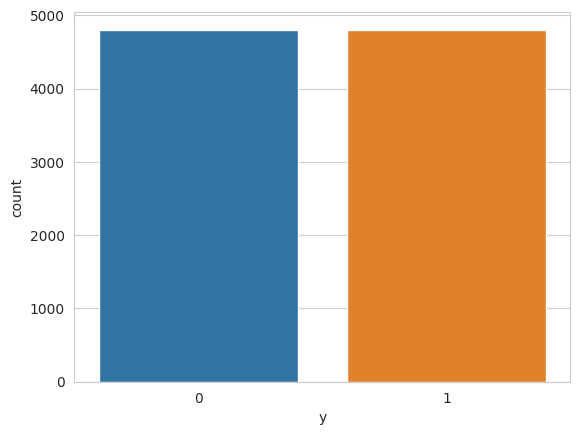

In [ ]:
sns.countplot(x = "y", data = df)
plt.show()

In [ ]:
df.head()

,review,y
0,great phone in budget. .. pubg performance was...,0
1,Best Smartphone by Mi in this Range. . be born...,0
2,Bad smooth phone. . and back camera quality is...,0
3,Thise is very nice mobile ...I like it very mu...,1
4,I m meagerly dissatisfy 👍 All section r superb...,0


# Cleaning

Remove unnecessary links, emojis, and make single code text



In [ ]:
# Remove URLS
import re

def remove_url(text):
    text = re.sub(r"http\S+", "", text)
    return text

In [ ]:
#Make code single code type
import unicodedata as uni

In [ ]:
#Remove Emojis

!pip install demoji

import demoji


def handle_emoji(string):
    emojis = demoji.findall(string)

    for emoji in emojis:
        string = string.replace(emoji, " " + emojis[emoji].split(":")[0])

    return string

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Perform all the text cleaning
def textcleaning(text):
    
    text = remove_url(text) 
    text = uni.normalize('NFKD', text)
    text = handle_emoji(text)
    text = text.lower() 
    text = re.sub(r'[^\w\s]', '', text)
    return text

In [ ]:
#Apply Text Cleaning

from tqdm import tqdm

tqdm.pandas()

df['clean_review'] = df['review'].progress_map(textcleaning)

100%|██████████| 9606/9606 [00:21<00:00, 449.23it/s]


In [ ]:
df.head()

,review,y,clean_review
0,great phone in budget. .. pubg performance was...,0,great phone in budget pubg performance was ro...
1,Best Smartphone by Mi in this Range. . be born...,0,best smartphone by mi in this range be born f...
2,Bad smooth phone. . and back camera quality is...,0,bad smooth phone and back camera quality is v...
3,Thise is very nice mobile ...I like it very mu...,1,thise is very nice mobile i like it very much ...
4,I m meagerly dissatisfy 👍 All section r superb...,0,i m meagerly dissatisfy thumbs up all section...


#Preprocessing

This will convert sentence into tokens, remove stop words, and lemmetization using POSTag

In [ ]:
# Word tokenize using NLTK
def word_tokenizer(text):
    text = text.lower()
    text = word_tokenize(text)

    return text

In [ ]:
# Remove stop words to optimize data collection
def remove_stopwords(text):
    text = [word for word in text if word not in en_stopwords]
    return text

In [ ]:
# Remove numbers
def remove_numbers(text):
    text = [word for word in text if not word.isnumeric()]
    return text

In [ ]:
# initialize Lemmetization using POSTag
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

# 1. Init Lemmatizer
lemmatizer = WordNetLemmatizer()

In [ ]:
# Lemmetization
def lemmatization(text):
  text = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in text]
  text = [word for word in text if not word.isnumeric()]
  return text

In [ ]:
# Compile Preprocessing
def preprocessing(text):

    text = word_tokenizer(text)
    text = remove_stopwords(text)
    text = remove_numbers(text)
    text = lemmatization(text)

    return text

In [ ]:
# Implement Preprocessing
from tqdm import tqdm

tqdm.pandas()

df['clean_review'] = df['clean_review'].progress_map(preprocessing)

100%|██████████| 9606/9606 [01:04<00:00, 148.46it/s]


In [ ]:
def sentence_from_tokens(text):
  text = " ".join(text)
  return text

In [ ]:
df['clean_review2'] = df['clean_review'].progress_map(sentence_from_tokens)

100%|██████████| 9606/9606 [00:00<00:00, 439986.94it/s]


In [ ]:
df.head()

,review,y,clean_review,clean_review2
0,great phone in budget. .. pubg performance was...,0,"[great, phone, budget, pubg, performance, roug...",great phone budget pubg performance rough came...
1,Best Smartphone by Mi in this Range. . be born...,0,"[best, smartphone, mi, range, born, r, confuse...",best smartphone mi range born r confuse samsun...
2,Bad smooth phone. . and back camera quality is...,0,"[bad, smooth, phone, back, camera, quality, ev...",bad smooth phone back camera quality evil rear...
3,Thise is very nice mobile ...I like it very mu...,1,"[thise, nice, mobile, like, much, delivery, al...",thise nice mobile like much delivery also fast...
4,I m meagerly dissatisfy 👍 All section r superb...,0,"[meagerly, dissatisfy, thumb, section, r, supe...",meagerly dissatisfy thumb section r superb del...


#Visualisation

Find top used words in the reviews collection


In [ ]:
list_of_word_list= df.clean_review.values.tolist()

In [ ]:
word_list = [item for sublist in list_of_word_list for item in sublist]

In [ ]:
word_list[:20]

['great',
 'phone',
 'budget',
 'pubg',
 'performance',
 'rough',
 'camera',
 'worsen',
 'old',
 'update',
 'ni8',
 'mode',
 'cam',
 'aadded',
 'phone',
 'also',
 'bad',
 'stupid',
 'phone',
 'best']

### Plot top 100 words

In [ ]:
top_N = 100 #top 100 words
word_dist = nltk.FreqDist(word_list)
top100_words = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Word', 'Frequency'])

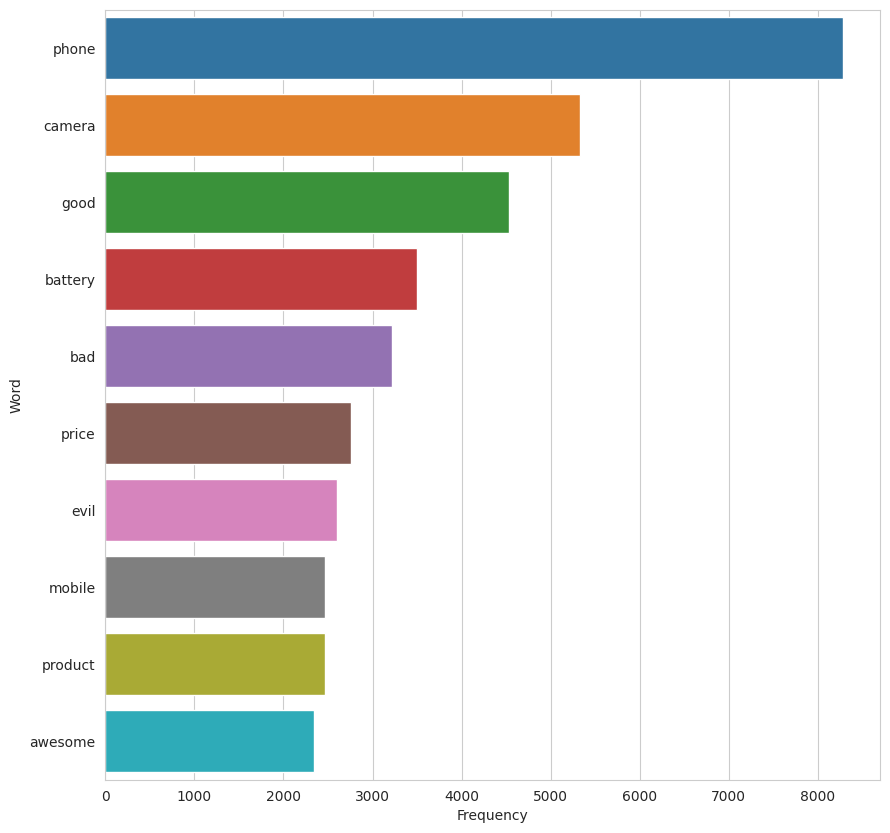

In [ ]:
plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.barplot(x="Frequency",y="Word", data=top100_words.head(10))

### Word Cloud

In [ ]:
def wc(data,bgcolor,title):
    plt.figure(figsize = (80,80))
    wc = WordCloud(background_color = bgcolor, max_words = 100,  max_font_size = 50)
    wc.generate(' '.join(data))
    plt.imshow(wc)
    plt.axis('off')

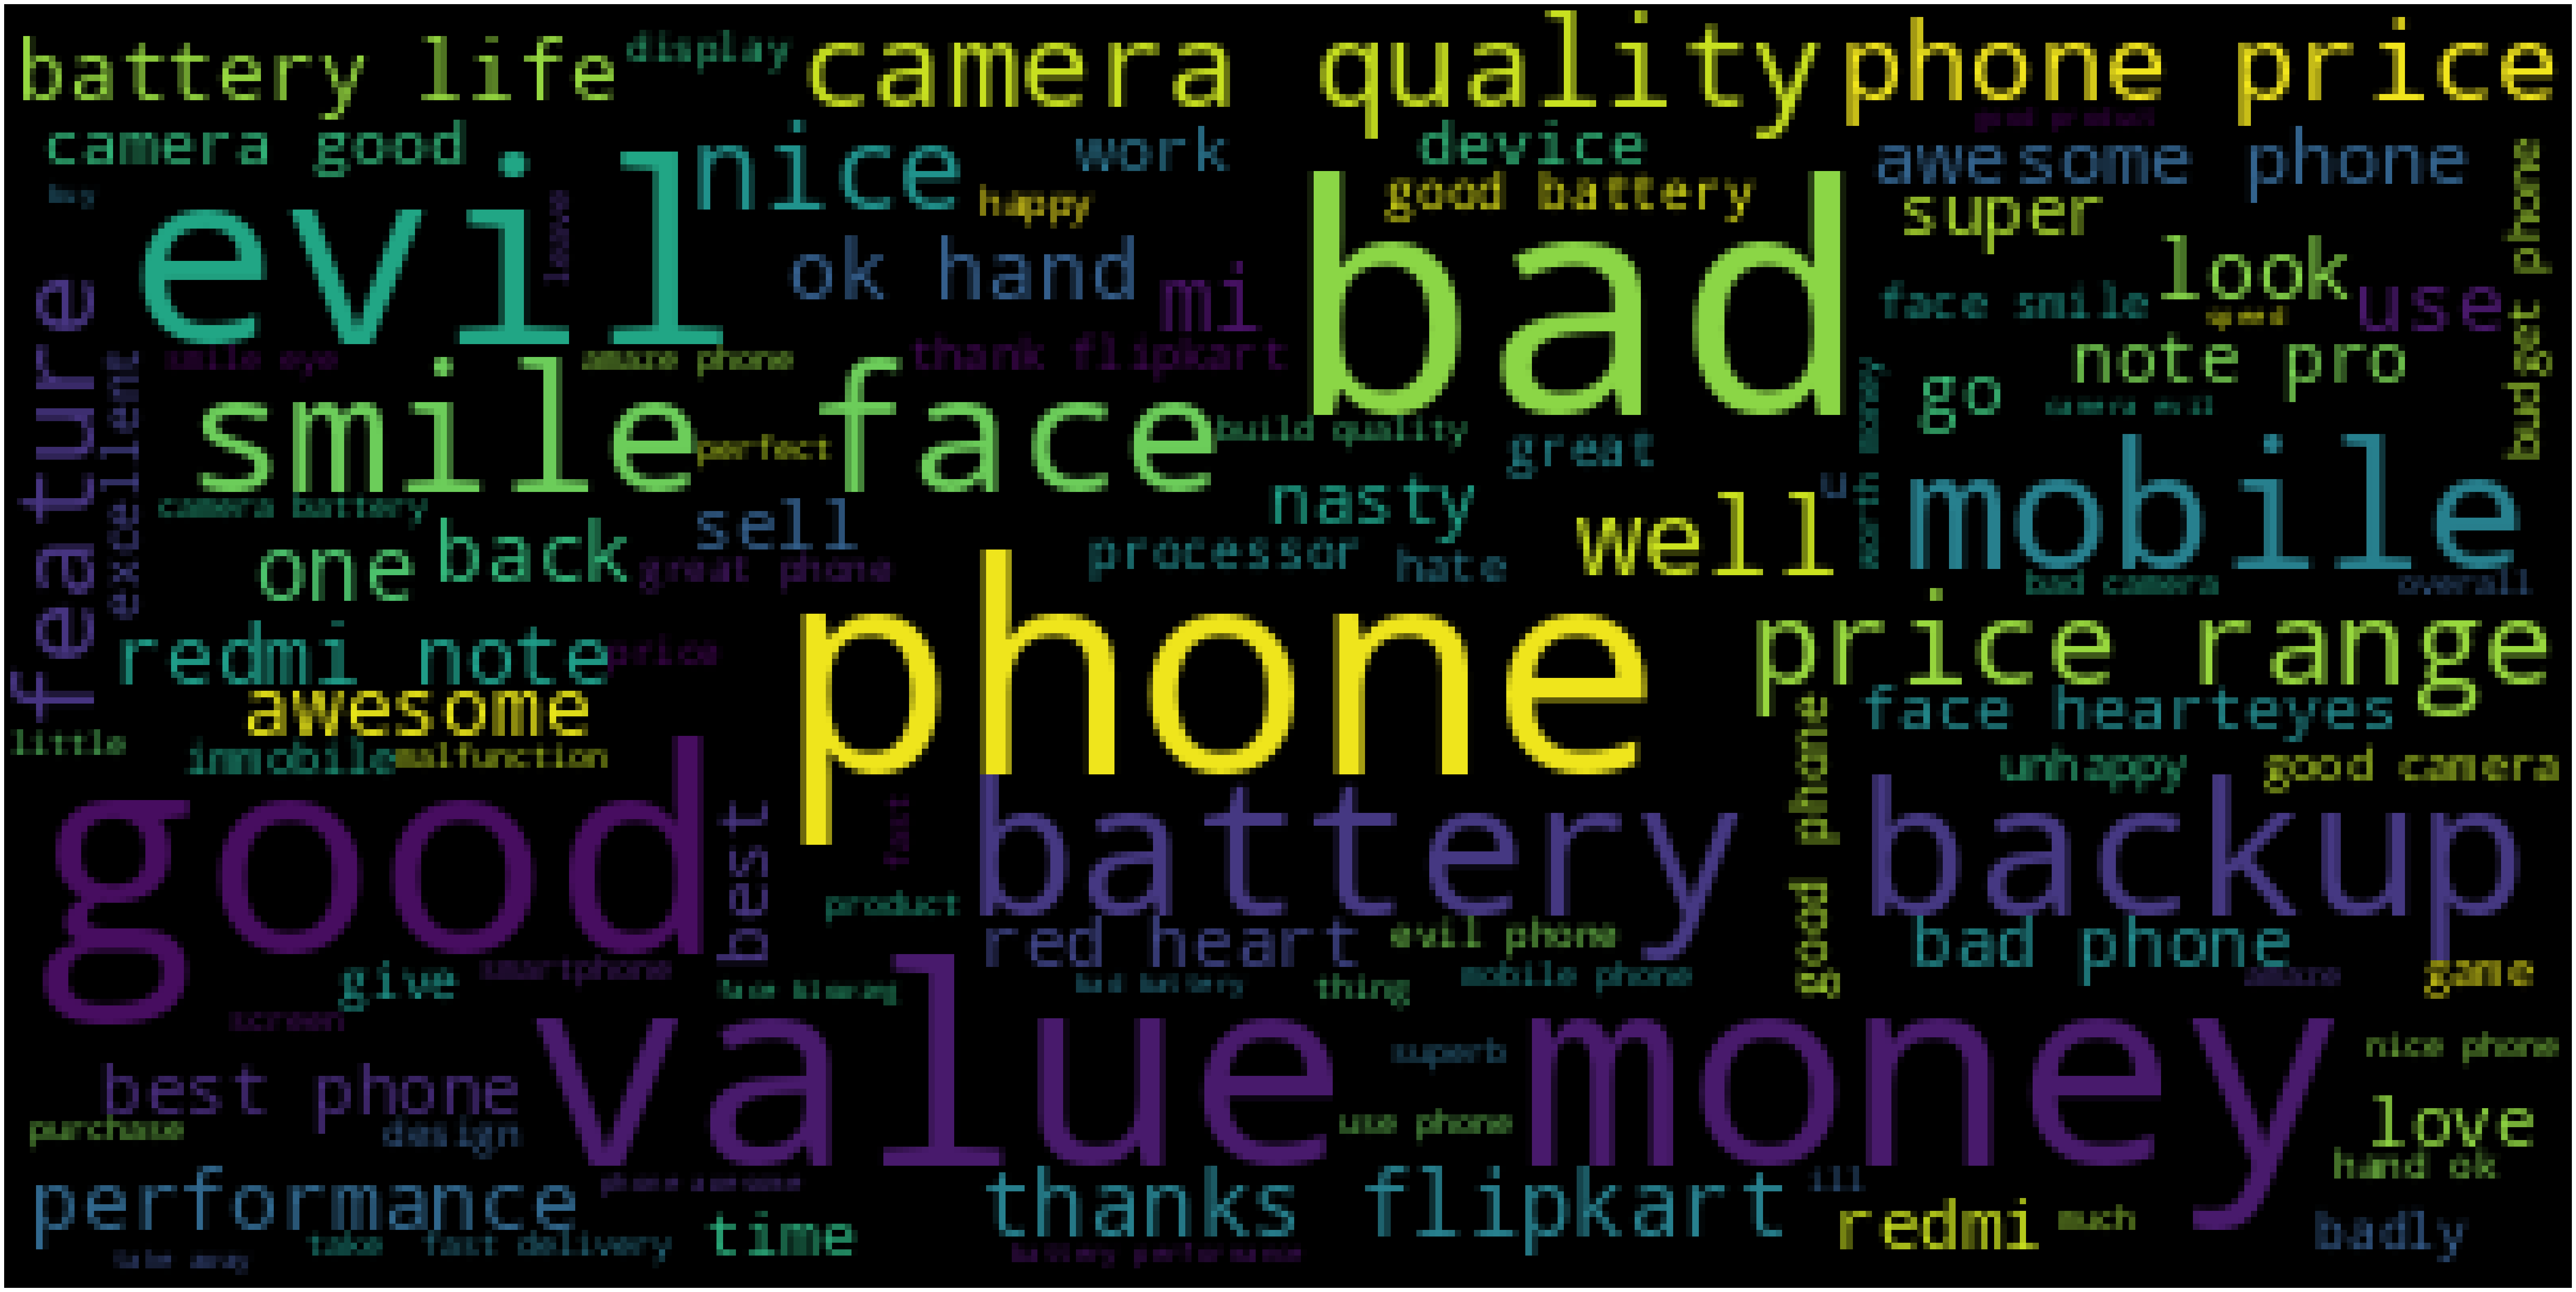

In [ ]:

wc(word_list,'black','Common Words' )

#Review Sentiment Analysis
This is perfomed to find overall sentiment of a review

In [ ]:
sent_analyser = SentimentIntensityAnalyzer()
def sentiment(text):
    text = " ".join(text)
    return (sent_analyser.polarity_scores(text)["compound"])

In [ ]:
from tqdm import tqdm
tqdm.pandas()

df["Sentence_Polarity"] = df["clean_review"].apply(sentiment)

In [ ]:
df.head()

,review,y,clean_review,clean_review2,Sentence_Polarity
0,great phone in budget. .. pubg performance was...,0,"[great, phone, budget, pubg, performance, roug...",great phone budget pubg performance rough came...,-0.7269
1,Best Smartphone by Mi in this Range. . be born...,0,"[best, smartphone, mi, range, born, r, confuse...",best smartphone mi range born r confuse samsun...,-0.6369
2,Bad smooth phone. . and back camera quality is...,0,"[bad, smooth, phone, back, camera, quality, ev...",bad smooth phone back camera quality evil rear...,-0.7579
3,Thise is very nice mobile ...I like it very mu...,1,"[thise, nice, mobile, like, much, delivery, al...",thise nice mobile like much delivery also fast...,0.8885
4,I m meagerly dissatisfy 👍 All section r superb...,0,"[meagerly, dissatisfy, thumb, section, r, supe...",meagerly dissatisfy thumb section r superb del...,0.9531


In [ ]:
def senti(data):
    if data['Sentence_Polarity'] >= 0.05:
        val = "Positive"
    elif data['Sentence_Polarity'] <= -0.05:
        val = "Negative"
    else:
        val = "Neutral"
    return val

In [ ]:
from tqdm import tqdm
tqdm.pandas()

df['Sentence_Sentiment'] = df.apply(senti, axis=1)

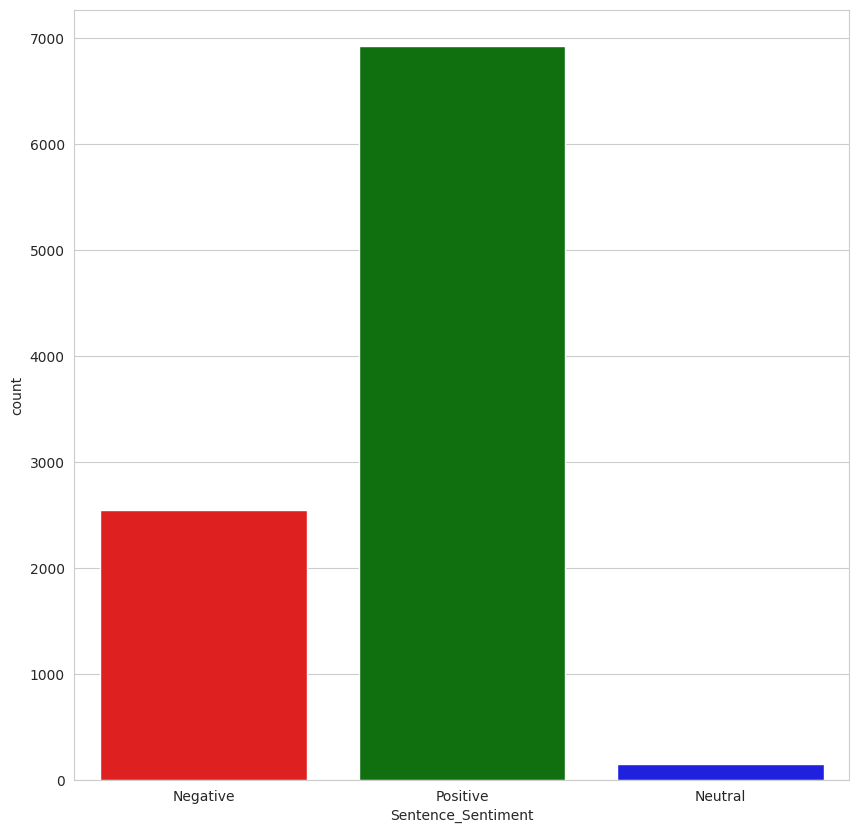

In [ ]:
plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.countplot(x="Sentence_Sentiment", data=df, 
                  palette=dict(Neutral="blue", Positive="Green", Negative="Red"))

#Aspect Extraction using Spacy
##We didn't put this as our final Approach

In [ ]:
#import spacy
nlp = spacy.load("en_core_web_sm")

In [ ]:
def pos(text):
    text = " ".join(text)
    doc = nlp(text)
    # You want list of Verb tokens 
    aspects = [token.text for token in doc if token.pos_ == "NOUN"]
    return aspects

In [ ]:
from tqdm import tqdm
tqdm.pandas()

df["Aspects"] = df["clean_review"].apply(pos)

In [ ]:
df.head()

,review,y,clean_review,clean_review2,Sentence_Polarity,Sentence_Sentiment,Aspects
0,great phone in budget. .. pubg performance was...,0,"[great, phone, budget, pubg, performance, roug...",great phone budget pubg performance rough came...,-0.7269,Negative,"[phone, budget, pubg, performance, camera, wor..."
1,Best Smartphone by Mi in this Range. . be born...,0,"[best, smartphone, mi, range, born, r, confuse...",best smartphone mi range born r confuse samsun...,-0.6369,Negative,"[range, confuse, price, range, display, phone]"
2,Bad smooth phone. . and back camera quality is...,0,"[bad, smooth, phone, back, camera, quality, ev...",bad smooth phone back camera quality evil rear...,-0.7579,Negative,"[phone, camera, quality, camera, bit, value, m..."
3,Thise is very nice mobile ...I like it very mu...,1,"[thise, nice, mobile, like, much, delivery, al...",thise nice mobile like much delivery also fast...,0.8885,Positive,"[mobile, delivery, lockdown]"
4,I m meagerly dissatisfy 👍 All section r superb...,0,"[meagerly, dissatisfy, thumb, section, r, supe...",meagerly dissatisfy thumb section r superb del...,0.9531,Positive,"[meagerly, section, r, delivery, guy, politene..."


#Aspect Extraction and its polarity Using LDA

In [ ]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(list_of_word_list)
# Create Corpus
texts = list_of_word_list
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 3), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1)]


In [ ]:
from gensim.models import LdaMulticore
from gensim.models import LdaModel
from pprint import pprint

# number of topics
num_topics = 10
# Build LDA model
lda_model = LdaMulticore(corpus=corpus, id2word=id2word,
                     num_topics=num_topics, iterations=400)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.034*"camera" + 0.033*"phone" + 0.018*"great" + 0.018*"battery" + '
  '0.016*"good" + 0.016*"best" + 0.015*"awesome" + 0.015*"price" + '
  '0.012*"product" + 0.012*"quality"'),
 (1,
  '0.034*"face" + 0.032*"phone" + 0.014*"smile" + 0.013*"camera" + '
  '0.013*"kiss" + 0.012*"awesome" + 0.012*"blowing" + 0.012*"good" + '
  '0.012*"price" + 0.011*"bad"'),
 (2,
  '0.046*"phone" + 0.034*"good" + 0.033*"camera" + 0.019*"battery" + '
  '0.017*"awesome" + 0.015*"mobile" + 0.014*"flipkart" + 0.013*"performance" + '
  '0.013*"great" + 0.012*"price"'),
 (3,
  '0.065*"phone" + 0.038*"bad" + 0.032*"evil" + 0.028*"camera" + 0.021*"price" '
  '+ 0.019*"battery" + 0.016*"flipkart" + 0.014*"awesome" + '
  '0.014*"performance" + 0.014*"redmi"'),
 (4,
  '0.061*"phone" + 0.024*"good" + 0.021*"battery" + 0.019*"nice" + '
  '0.018*"camera" + 0.014*"price" + 0.011*"flipkart" + 0.011*"redmi" + '
  '0.011*"great" + 0.010*"best"'),
 (5,
  '0.034*"phone" + 0.033*"camera" + 0.023*"good" + 0.021*"battery

In [ ]:
doc_lda

In [ ]:
%%time
from gensim.models import FastText
fasttext_model = FastText(list_of_word_list, vector_size= 100, window=5, min_count=5, workers=4,sg=1)
# fasttext_model = FastText.load_fasttext_format("../input/fast100/cc.en.100.bin")

CPU times: user 14.6 s, sys: 534 ms, total: 15.1 s
Wall time: 9.55 s


In [ ]:
import pickle
with open("gensim_words_list", "wb") as fp:   #Pickling
  pickle.dump(list_of_word_list, fp)

In [ ]:
fasttext_model.save("FastText-Model-For-ABSA.bin")

In [ ]:
fasttext_model.wv.n_similarity("I really like the camera of this phone", "camera")

0.9004752

In [ ]:
aspects = ["phone", "camera", "battery", "delivery", "processor"]

def get_similarity(text, aspect):
    try:
        text = " ".join(text)
        return fasttext_model.wv.n_similarity(text, aspect)
    except:
        return 0


In [ ]:
from tqdm import tqdm
tqdm.pandas()
for aspect in aspects:
    df[aspect] = df['clean_review'].progress_map(lambda text: get_similarity(text, aspect))

100%|██████████| 9606/9606 [00:14<00:00, 662.61it/s]


In [ ]:
df.head()

,review,y,clean_review,clean_review2,Sentence_Polarity,Sentence_Sentiment,Aspects,phone,camera,battery,delivery,processor
0,great phone in budget. .. pubg performance was...,0,"[great, phone, budget, pubg, performance, roug...",great phone budget pubg performance rough came...,-0.7269,Negative,"[phone, budget, pubg, performance, camera, wor...",0.968407,0.848900,0.917512,0.893750,0.957045
1,Best Smartphone by Mi in this Range. . be born...,0,"[best, smartphone, mi, range, born, r, confuse...",best smartphone mi range born r confuse samsun...,-0.6369,Negative,"[range, confuse, price, range, display, phone]",0.972910,0.822940,0.925842,0.909213,0.943074
2,Bad smooth phone. . and back camera quality is...,0,"[bad, smooth, phone, back, camera, quality, ev...",bad smooth phone back camera quality evil rear...,-0.7579,Negative,"[phone, camera, quality, camera, bit, value, m...",0.945815,0.901373,0.940936,0.923134,0.967318
3,Thise is very nice mobile ...I like it very mu...,1,"[thise, nice, mobile, like, much, delivery, al...",thise nice mobile like much delivery also fast...,0.8885,Positive,"[mobile, delivery, lockdown]",0.951361,0.898044,0.933809,0.933628,0.949737
4,I m meagerly dissatisfy 👍 All section r superb...,0,"[meagerly, dissatisfy, thumb, section, r, supe...",meagerly dissatisfy thumb section r superb del...,0.9531,Positive,"[meagerly, section, r, delivery, guy, politene...",0.940759,0.873417,0.954892,0.944301,0.949561


In [ ]:
df.to_csv("Clean_Flipkart_Product.csv", index = False)

#Model
Find polarity of aspects


In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import RandomSampler
import warnings

In [ ]:
class config:
    warnings.filterwarnings("ignore", category = UserWarning)
    IMG_SIZE = (224,224)
    DEVICE = ("cuda" if torch.cuda.is_available() else "cpu")
    FOLDS = 2
    SHUFFLE = True
    BATCH_SIZE = 32
    LR = 0.01
    EPOCHS = 30
    EMB_DIM = 100
    MAX_LEN = 20
    MODEL_PATH = "./Models/MyModel.pt"

In [ ]:
df.head()

,review,y,clean_review,clean_review2,Sentence_Polarity,Sentence_Sentiment,Aspects,phone,camera,battery,delivery,processor
0,great phone in budget. .. pubg performance was...,0,"[great, phone, budget, pubg, performance, roug...",great phone budget pubg performance rough came...,-0.7269,Negative,"[phone, budget, pubg, performance, camera, wor...",0.968407,0.848900,0.917512,0.893750,0.957045
1,Best Smartphone by Mi in this Range. . be born...,0,"[best, smartphone, mi, range, born, r, confuse...",best smartphone mi range born r confuse samsun...,-0.6369,Negative,"[range, confuse, price, range, display, phone]",0.972910,0.822940,0.925842,0.909213,0.943074
2,Bad smooth phone. . and back camera quality is...,0,"[bad, smooth, phone, back, camera, quality, ev...",bad smooth phone back camera quality evil rear...,-0.7579,Negative,"[phone, camera, quality, camera, bit, value, m...",0.945815,0.901373,0.940936,0.923134,0.967318
3,Thise is very nice mobile ...I like it very mu...,1,"[thise, nice, mobile, like, much, delivery, al...",thise nice mobile like much delivery also fast...,0.8885,Positive,"[mobile, delivery, lockdown]",0.951361,0.898044,0.933809,0.933628,0.949737
4,I m meagerly dissatisfy 👍 All section r superb...,0,"[meagerly, dissatisfy, thumb, section, r, supe...",meagerly dissatisfy thumb section r superb del...,0.9531,Positive,"[meagerly, section, r, delivery, guy, politene...",0.940759,0.873417,0.954892,0.944301,0.949561


#DataSet Generator

###Creation of the Vocabulary 

In [ ]:
class Vocabulary:
  
    '''
    __init__ method is called by default as soon as an object of this class is initiated
    we use this method to initiate our vocab dictionaries
    '''
    def __init__(self, freq_threshold, max_size):
        '''
        freq_threshold : the minimum times a word must occur in corpus to be treated in vocab
        max_size : max source vocab size. Eg. if set to 10,000, we pick the top 10,000 most frequent words and discard others
        '''
        #initiate the index to token dict
        ## <PAD> -> padding, used for padding the shorter sentences in a batch to match the length of longest sentence in the batch
        ## <SOS> -> start token, added in front of each sentence to signify the start of sentence
        ## <EOS> -> End of sentence token, added to the end of each sentence to signify the end of sentence
        ## <UNK> -> words which are not found in the vocab are replace by this token
        self.itos = {0: '<PAD>', 1:'<SOS>', 2:'<EOS>', 3: '<UNK>'}
        #initiate the token to index dict
        self.stoi = {k:j for j,k in self.itos.items()} 
        
        self.freq_threshold = freq_threshold
        self.max_size = max_size
    
    '''
    __len__ is used by dataloader later to create batches
    '''
    def __len__(self):
        return len(self.itos)
    
    '''
    a simple tokenizer to split on space and converts the sentence to list of words
    '''
    @staticmethod
    def tokenizer(text):
        return [tok.lower().strip() for tok in text.split(' ')]
    
    '''
    build the vocab: create a dictionary mapping of index to string (itos) and string to index (stoi)
    output ex. for stoi -> {'the':5, 'a':6, 'an':7}
    '''
    def build_vocabulary(self, sentence_list):
        #calculate the frequencies of each word first to remove the words with freq < freq_threshold
        frequencies = {}  #init the freq dict
        idx = 4 #index from which we want our dict to start. We already used 4 indexes for pad, start, end, unk
        
        #calculate freq of words
        for sentence in sentence_list:
            for word in self.tokenizer(sentence):
                if word not in frequencies.keys():
                    frequencies[word]=1
                else:
                    frequencies[word]+=1
                    
                    
        #limit vocab by removing low freq words
        frequencies = {k:v for k,v in frequencies.items() if v>self.freq_threshold} 
        
        #limit vocab to the max_size specified
        frequencies = dict(sorted(frequencies.items(), key = lambda x: -x[1])[:self.max_size-idx]) # idx =4 for pad, start, end , unk
            
        #create vocab
        for word in frequencies.keys():
            self.stoi[word] = idx
            self.itos[idx] = word
            idx+=1
            
     
    '''
    convert the list of words to a list of corresponding indexes
    '''    
    def numericalize(self, text):
        #tokenize text
        tokenized_text = self.tokenizer(text)
        numericalized_text = []
        for token in tokenized_text:
            if token in self.stoi.keys():
                numericalized_text.append(self.stoi[token])
            else: #out-of-vocab words are represented by UNK token index
                numericalized_text.append(self.stoi['<UNK>'])
                
        return numericalized_text


In [ ]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    '''
    Initiating Variables
    df: the training dataframe
    source_column : the name of source text column in the dataframe
    transform : If we want to add any augmentation
    freq_threshold : the minimum times a word must occur in corpus to be treated in vocab
    source_vocab_max_size : max source vocab size
    '''
    
    def __init__(self, df, source_column,freq_threshold = 3,
                source_vocab_max_size = 10000 , transform=None):
    
        self.df = df
        self.transform = transform
        
        #get source and target texts
        self.source_texts = self.df[source_column]
        
        
        ##VOCAB class has been created above
        #Initialize source vocab object and build vocabulary
        self.source_vocab = Vocabulary(freq_threshold, source_vocab_max_size)
        self.source_vocab.build_vocabulary(self.source_texts.tolist())

        
    def __len__(self):
        return len(self.df)
    
    '''
    __getitem__ runs on 1 example at a time. Here, we get an example at index and return its numericalize source and
    target values using the vocabulary objects we created in __init__
    '''
    def __getitem__(self, index):
        source_text = self.source_texts[index]
        
        if self.transform is not None:
            source_text = self.transform(source_text)
            
        #numericalize texts ['<SOS>','cat', 'in', 'a', 'bag','<EOS>'] -> [1,12,2,9,24,2]
        numerialized_source = [self.source_vocab.stoi["<SOS>"]]
        numerialized_source += self.source_vocab.numericalize(source_text)
        numerialized_source.append(self.source_vocab.stoi["<EOS>"])
        
        #convert the list to tensor and return
        return torch.tensor(numerialized_source), torch.tensor(self.df.y[index])

In [ ]:
df.head()

,review,y,clean_review,clean_review2,Sentence_Polarity,Sentence_Sentiment,Aspects,phone,camera,battery,delivery,processor
0,great phone in budget. .. pubg performance was...,0,"[great, phone, budget, pubg, performance, roug...",great phone budget pubg performance rough came...,-0.7269,Negative,"[phone, budget, pubg, performance, camera, wor...",0.968407,0.848900,0.917512,0.893750,0.957045
1,Best Smartphone by Mi in this Range. . be born...,0,"[best, smartphone, mi, range, born, r, confuse...",best smartphone mi range born r confuse samsun...,-0.6369,Negative,"[range, confuse, price, range, display, phone]",0.972910,0.822940,0.925842,0.909213,0.943074
2,Bad smooth phone. . and back camera quality is...,0,"[bad, smooth, phone, back, camera, quality, ev...",bad smooth phone back camera quality evil rear...,-0.7579,Negative,"[phone, camera, quality, camera, bit, value, m...",0.945815,0.901373,0.940936,0.923134,0.967318
3,Thise is very nice mobile ...I like it very mu...,1,"[thise, nice, mobile, like, much, delivery, al...",thise nice mobile like much delivery also fast...,0.8885,Positive,"[mobile, delivery, lockdown]",0.951361,0.898044,0.933809,0.933628,0.949737
4,I m meagerly dissatisfy 👍 All section r superb...,0,"[meagerly, dissatisfy, thumb, section, r, supe...",meagerly dissatisfy thumb section r superb del...,0.9531,Positive,"[meagerly, section, r, delivery, guy, politene...",0.940759,0.873417,0.954892,0.944301,0.949561


In [ ]:
dataset = CustomDataset(df, "clean_review2")

In [ ]:
len(dataset.source_vocab.stoi)

3217

In [ ]:
dataset

Saving the pytorch custom dataset

In [ ]:
import pickle

with open('dataset-new', 'wb') as dataset_file:
 
  # Step 3
    pickle.dump(dataset, dataset_file, pickle.HIGHEST_PROTOCOL)

# import pickle
 
# # Step 2
# with open('./dataset', 'rb') as config_dictionary_file:
 
#     # Step 3
#     config_dictionary = pickle.load(config_dictionary_file)
 
#     # After config_dictionary is read from file
#     print(config_dictionary)

###Word Embeddings

In [ ]:
def get_emb_layer_with_weights(target_vocab, emb_model, trainable = False):

    weights_matrix = np.zeros((len(target_vocab), config.EMB_DIM))
    words_found = 0
    
    for i, word in enumerate(target_vocab):
        weights_matrix[i] = np.concatenate([emb_model.wv[word]])
        words_found += 1
                
    print(f"Words found are : {words_found}")
    
    weights_matrix = torch.tensor(weights_matrix, dtype = torch.float32).reshape(len(target_vocab), config.EMB_DIM)
    emb_layer = nn.Embedding.from_pretrained(weights_matrix)
    print(emb_layer)
    if trainable:
        emb_layer.weight.requires_grad = True
    else:
        emb_layer.weight.requires_grad = False

    return emb_layer

In [ ]:
class MyCollate:
    def __init__(self, pad_idx, maxlen):
        self.pad_idx = pad_idx
        self.maxlen = maxlen
        
    
    #__call__: a default method
    ##   First the obj is created using MyCollate(pad_idx) in data loader
    ##   Then if obj(batch) is called -> __call__ runs by default
    def __call__(self, batch):
        #get all source indexed sentences of the batch
        source = [item[0] for item in batch] 
        #pad them using pad_sequence method from pytorch. 
#         source = pad_sequence(source, batch_first=False, padding_value = self.pad_idx)
        
        padded_sequence = torch.zeros((self.maxlen, len(batch)), dtype = torch.int)
        
        for idx, text in enumerate(source):
            
            if len(text) > self.maxlen:
                padded_sequence[:, idx] = source[idx][: self.maxlen]
            else:
                padded_sequence[:len(source[idx]), idx] = padded_sequence[:len(source[idx]), idx] + source[idx]
                
        
        #get all target indexed sentences of the batch
        target = [item[1] for item in batch] 
        
        target = torch.tensor(target, dtype = torch.float32).reshape(-1)
        return padded_sequence, target


###Initializing the Model

In [ ]:
class Model(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, embedding_layer):
        super().__init__()
#         self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.hidden_dim = hidden_dim
        self.embedding = embedding_layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional = True)
        self.fc1 = nn.Linear(2*hidden_dim, 128)
        self.fc2 = nn.Linear(128, output_dim)
        self.dropout = nn.Dropout(0.3)
        self.sigmoid = nn.Sigmoid()


        
    def forward(self, text):
        
        max_len, N = text.shape
        hidden = torch.zeros((2, N , self.hidden_dim),
                          dtype=torch.float)
        memory = torch.zeros((2, N , self.hidden_dim),
                          dtype=torch.float)
        hidden = hidden.to(config.DEVICE)
        memory = memory.to(config.DEVICE)
        embedded = self.embedding(text)
        output, hidden = self.lstm(embedded, (hidden, memory))
#         assert torch.equal(output[-1,:,:], hidden.squeeze(0))
        y_pred = output[-1,:,:]
        y_pred = self.fc1(y_pred)
        y_pred = self.fc2(y_pred)
        y_pred = self.sigmoid(y_pred)
                         
        return y_pred  

###Training and K-fold Cross Validation

In [ ]:
def train_epochs(dataloader,model, loss_fn, optimizer):
    train_correct = 0
    train_loss = 0
    
    model.train()

    for review, label in tqdm(dataloader):
        
        review, label = review.to(config.DEVICE), label.to(config.DEVICE)
        optimizer.zero_grad()
        output = model(review)
        output = output.reshape(-1)
        loss = loss_fn(output, label)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()*review.size(1)
        prediction = (output > 0.5).float()
        train_correct += (prediction == label).float().sum()
        
    return train_loss, train_correct

        

In [ ]:
def val_epochs(dataloader, model, loss_fn):
    val_correct = 0
    val_loss = 0
    
    model.eval()
#     hidden = model.init_hidden(config.BATCH_SIZE)

    for review, label in dataloader:
        
        review, label = review.to(config.DEVICE), label.to(config.DEVICE)
        
        output = model(review)
        output = output.reshape(-1)

        loss = loss_fn(output, label)
        
        val_loss += loss.item()*review.size(1)
        prediction = (output > 0.5).float()
        val_correct += (prediction == label).float().sum()
#         prediction = 
    return val_loss, val_correct

        

Words found are : 3217
Embedding(3217, 100)
-----------------------------------------------------------0-fold of the model-----------------------------------------------------------


100%|██████████| 151/151 [00:06<00:00, 24.96it/s]


| Train Loss : 0.6931551166333284 |  Val Loss : 0.6926843681212344 | Train Acc : 50.92650604248047 | Val Acc : 49.69810485839844 |


100%|██████████| 151/151 [00:04<00:00, 31.90it/s]


| Train Loss : 0.6915308536526166 |  Val Loss : 0.6912243608854572 | Train Acc : 52.65458679199219 | Val Acc : 49.843849182128906 |


100%|██████████| 151/151 [00:05<00:00, 29.61it/s]


| Train Loss : 0.6890335931222984 |  Val Loss : 0.6871528569395632 | Train Acc : 55.09056854248047 | Val Acc : 57.67228698730469 |


100%|██████████| 151/151 [00:05<00:00, 26.81it/s]


| Train Loss : 0.6828972862061178 |  Val Loss : 0.6758740706143964 | Train Acc : 60.25400924682617 | Val Acc : 63.793460845947266 |


100%|██████████| 151/151 [00:04<00:00, 30.32it/s]


| Train Loss : 0.6291434943192009 |  Val Loss : 1.5942883048033605 | Train Acc : 68.41557312011719 | Val Acc : 49.69810485839844 |


100%|██████████| 151/151 [00:05<00:00, 25.32it/s]


| Train Loss : 0.581567707606313 |  Val Loss : 1.8547386319940595 | Train Acc : 73.01686096191406 | Val Acc : 50.30189895629883 |


100%|██████████| 151/151 [00:04<00:00, 32.11it/s]


| Train Loss : 0.37109953206317164 |  Val Loss : 0.33876091658808455 | Train Acc : 85.280029296875 | Val Acc : 84.3431167602539 |


100%|██████████| 151/151 [00:07<00:00, 21.06it/s]


| Train Loss : 0.262123891159616 |  Val Loss : 0.15615271339543954 | Train Acc : 89.81886291503906 | Val Acc : 94.21194458007812 |


100%|██████████| 151/151 [00:05<00:00, 29.94it/s]


| Train Loss : 0.2228242795299347 |  Val Loss : 0.38916503946259445 | Train Acc : 91.50531005859375 | Val Acc : 85.23838806152344 |


100%|██████████| 151/151 [00:04<00:00, 32.15it/s]


| Train Loss : 0.2337529609740314 |  Val Loss : 0.14854395253552377 | Train Acc : 90.5892105102539 | Val Acc : 94.60753631591797 |


100%|██████████| 151/151 [00:05<00:00, 25.61it/s]


| Train Loss : 0.20733748244514522 |  Val Loss : 1.205677232617218 | Train Acc : 92.1923828125 | Val Acc : 61.21174240112305 |


100%|██████████| 151/151 [00:04<00:00, 31.31it/s]


| Train Loss : 0.1986121209099805 |  Val Loss : 0.15101016379967286 | Train Acc : 91.9633560180664 | Val Acc : 94.08702850341797 |


100%|██████████| 151/151 [00:06<00:00, 24.92it/s]


| Train Loss : 0.18078822249792129 |  Val Loss : 0.14084540845839066 | Train Acc : 92.87944793701172 | Val Acc : 94.48261260986328 |


100%|██████████| 151/151 [00:04<00:00, 30.54it/s]


| Train Loss : 0.17799151432976767 |  Val Loss : 0.16373079383287012 | Train Acc : 92.96273040771484 | Val Acc : 93.77472686767578 |


100%|██████████| 151/151 [00:05<00:00, 26.71it/s]


| Train Loss : 0.18281859327158084 |  Val Loss : 0.3300505113034049 | Train Acc : 92.73371124267578 | Val Acc : 87.29960632324219 |


100%|██████████| 151/151 [00:04<00:00, 30.21it/s]


| Train Loss : 0.1677262852584151 |  Val Loss : 0.15498979105171054 | Train Acc : 93.1292953491211 | Val Acc : 93.67062377929688 |


100%|██████████| 151/151 [00:04<00:00, 32.62it/s]


| Train Loss : 0.1612906955795193 |  Val Loss : 0.15986331939038378 | Train Acc : 93.3375015258789 | Val Acc : 93.56652069091797 |


100%|██████████| 151/151 [00:05<00:00, 26.79it/s]


| Train Loss : 0.15627732812358147 |  Val Loss : 0.15068404239377653 | Train Acc : 93.75390625 | Val Acc : 94.12866973876953 |


100%|██████████| 151/151 [00:04<00:00, 31.65it/s]


| Train Loss : 0.1580373495665939 |  Val Loss : 0.21143689686783448 | Train Acc : 93.67062377929688 | Val Acc : 93.17093658447266 |


100%|██████████| 151/151 [00:05<00:00, 25.89it/s]


| Train Loss : 0.15660001847545135 |  Val Loss : 0.15183264259097726 | Train Acc : 93.77472686767578 | Val Acc : 94.19113159179688 |


100%|██████████| 151/151 [00:04<00:00, 31.84it/s]


| Train Loss : 0.16684410949405373 |  Val Loss : 0.16847641652520934 | Train Acc : 93.06683349609375 | Val Acc : 93.77472686767578 |


100%|██████████| 151/151 [00:06<00:00, 24.70it/s]


| Train Loss : 0.15097379442416836 |  Val Loss : 0.15272245696076261 | Train Acc : 93.77472686767578 | Val Acc : 94.10784912109375 |


100%|██████████| 151/151 [00:04<00:00, 32.43it/s]


| Train Loss : 0.18039712283194884 |  Val Loss : 0.1386848858988303 | Train Acc : 93.19175720214844 | Val Acc : 94.73246002197266 |


100%|██████████| 151/151 [00:05<00:00, 28.39it/s]


| Train Loss : 0.16013800916076065 |  Val Loss : 0.14141370132394862 | Train Acc : 93.5248794555664 | Val Acc : 94.44097137451172 |


100%|██████████| 151/151 [00:05<00:00, 30.16it/s]


| Train Loss : 0.1514084765141938 |  Val Loss : 0.16092925473610212 | Train Acc : 93.96211242675781 | Val Acc : 93.56652069091797 |


100%|██████████| 151/151 [00:04<00:00, 31.99it/s]


| Train Loss : 0.14332317210176998 |  Val Loss : 0.22919000612578427 | Train Acc : 94.1703109741211 | Val Acc : 91.92171478271484 |


100%|██████████| 151/151 [00:05<00:00, 25.23it/s]


| Train Loss : 0.1547192595356173 |  Val Loss : 0.14723935975225275 | Train Acc : 93.69144439697266 | Val Acc : 94.54507446289062 |


100%|██████████| 151/151 [00:04<00:00, 30.89it/s]


| Train Loss : 0.15567668737557042 |  Val Loss : 0.28829810426919694 | Train Acc : 93.79554748535156 | Val Acc : 88.77784729003906 |


100%|██████████| 151/151 [00:05<00:00, 25.17it/s]


| Train Loss : 0.1429782140920144 |  Val Loss : 0.6130304851309597 | Train Acc : 94.39933013916016 | Val Acc : 67.08306884765625 |


100%|██████████| 151/151 [00:04<00:00, 31.47it/s]


| Train Loss : 0.14164572652375437 |  Val Loss : 0.14525084572784291 | Train Acc : 94.12866973876953 | Val Acc : 94.39933013916016 |


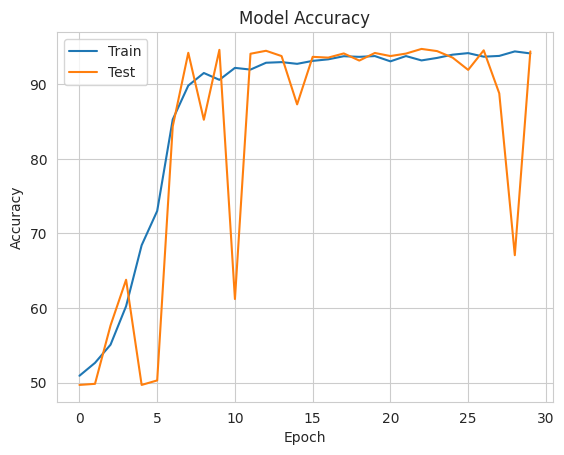

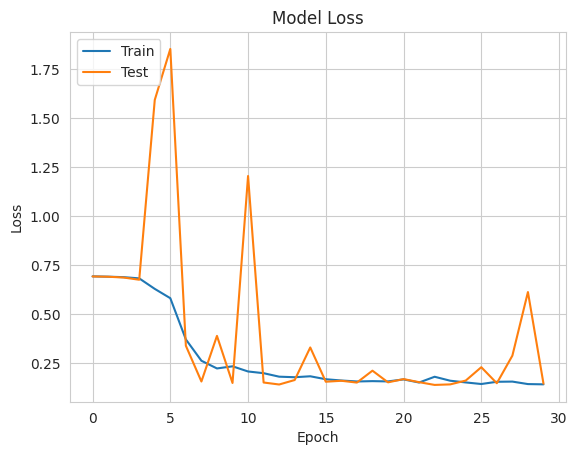

Words found are : 3217
Embedding(3217, 100)
-----------------------------------------------------------1-fold of the model-----------------------------------------------------------


100%|██████████| 151/151 [00:05<00:00, 27.96it/s]


| Train Loss : 0.6926276564052049 |  Val Loss : 0.6918074840956272 | Train Acc : 51.11388397216797 | Val Acc : 55.6110725402832 |


100%|██████████| 151/151 [00:05<00:00, 28.42it/s]


| Train Loss : 0.6907954869755799 |  Val Loss : 0.6902510368176209 | Train Acc : 53.23755645751953 | Val Acc : 55.38205337524414 |


100%|██████████| 151/151 [00:04<00:00, 30.31it/s]


| Train Loss : 0.6883425617277585 |  Val Loss : 0.68667542804114 | Train Acc : 55.21548843383789 | Val Acc : 56.50634765625 |


100%|██████████| 151/151 [00:05<00:00, 25.39it/s]


| Train Loss : 0.6823800084567582 |  Val Loss : 0.6788616477636503 | Train Acc : 57.7347526550293 | Val Acc : 55.6110725402832 |


100%|██████████| 151/151 [00:04<00:00, 31.42it/s]


| Train Loss : 0.6496736059617232 |  Val Loss : 0.9550179645540117 | Train Acc : 65.45909118652344 | Val Acc : 50.322715759277344 |


100%|██████████| 151/151 [00:06<00:00, 24.84it/s]


| Train Loss : 0.46273077549864644 |  Val Loss : 0.282023319311001 | Train Acc : 79.40870666503906 | Val Acc : 89.71475982666016 |


100%|██████████| 151/151 [00:04<00:00, 31.15it/s]


| Train Loss : 0.3171350651905608 |  Val Loss : 0.23884359415982778 | Train Acc : 88.17405700683594 | Val Acc : 90.50593566894531 |


100%|██████████| 151/151 [00:05<00:00, 27.99it/s]


| Train Loss : 0.2742775873811002 |  Val Loss : 0.31291994360643405 | Train Acc : 89.6731185913086 | Val Acc : 86.71663665771484 |


100%|██████████| 151/151 [00:05<00:00, 28.44it/s]


| Train Loss : 0.22805857219076545 |  Val Loss : 0.368747405594596 | Train Acc : 91.2554702758789 | Val Acc : 84.92608642578125 |


100%|██████████| 151/151 [00:04<00:00, 31.07it/s]


| Train Loss : 0.19646696559580668 |  Val Loss : 0.20098828173927186 | Train Acc : 92.52550506591797 | Val Acc : 93.10847473144531 |


100%|██████████| 151/151 [00:06<00:00, 25.13it/s]


| Train Loss : 0.19417602637235495 |  Val Loss : 0.16413216628002394 | Train Acc : 92.94190979003906 | Val Acc : 93.77472686767578 |


100%|██████████| 151/151 [00:04<00:00, 31.33it/s]


| Train Loss : 0.1785678415342641 |  Val Loss : 0.16850564496829415 | Train Acc : 93.1292953491211 | Val Acc : 93.60816192626953 |


100%|██████████| 151/151 [00:05<00:00, 25.28it/s]


| Train Loss : 0.17062888322535738 |  Val Loss : 0.21244343600092197 | Train Acc : 93.79554748535156 | Val Acc : 91.9633560180664 |


100%|██████████| 151/151 [00:04<00:00, 30.47it/s]


| Train Loss : 0.1772153506858432 |  Val Loss : 0.15433636802250014 | Train Acc : 92.85862731933594 | Val Acc : 93.94129180908203 |


100%|██████████| 151/151 [00:05<00:00, 26.90it/s]


| Train Loss : 0.1639720781991507 |  Val Loss : 0.32536655146215215 | Train Acc : 94.06620788574219 | Val Acc : 84.6554183959961 |


100%|██████████| 151/151 [00:05<00:00, 29.62it/s]


| Train Loss : 0.1626431113626717 |  Val Loss : 1.3003857400599506 | Train Acc : 93.81636047363281 | Val Acc : 57.443267822265625 |


100%|██████████| 151/151 [00:04<00:00, 31.15it/s]


| Train Loss : 0.16923390308310873 |  Val Loss : 0.20515197497803594 | Train Acc : 93.5248794555664 | Val Acc : 92.52550506591797 |


100%|██████████| 151/151 [00:06<00:00, 25.06it/s]


| Train Loss : 0.15277409130331596 |  Val Loss : 0.2718467433304184 | Train Acc : 94.06620788574219 | Val Acc : 89.52738189697266 |


100%|██████████| 151/151 [00:06<00:00, 25.10it/s]


| Train Loss : 0.1517406998998376 |  Val Loss : 0.1573436798965285 | Train Acc : 94.4617919921875 | Val Acc : 93.75390625 |


100%|██████████| 151/151 [00:06<00:00, 24.70it/s]


| Train Loss : 0.14785261999163407 |  Val Loss : 1.7287121347752605 | Train Acc : 94.29523468017578 | Val Acc : 56.61045455932617 |


100%|██████████| 151/151 [00:04<00:00, 30.65it/s]


| Train Loss : 0.15731023484870074 |  Val Loss : 0.14506537214923257 | Train Acc : 94.21194458007812 | Val Acc : 94.21194458007812 |


100%|██████████| 151/151 [00:05<00:00, 29.80it/s]


| Train Loss : 0.1466883203410684 |  Val Loss : 0.14829820202085317 | Train Acc : 94.39933013916016 | Val Acc : 94.19113159179688 |


100%|██████████| 151/151 [00:05<00:00, 25.38it/s]


| Train Loss : 0.14512208814793034 |  Val Loss : 0.1451438107182061 | Train Acc : 94.81574249267578 | Val Acc : 94.21194458007812 |


100%|██████████| 151/151 [00:04<00:00, 31.46it/s]


| Train Loss : 0.13914938114816952 |  Val Loss : 0.1539748425807012 | Train Acc : 94.6908187866211 | Val Acc : 94.35769653320312 |


100%|██████████| 151/151 [00:06<00:00, 23.84it/s]


| Train Loss : 0.1364828471469381 |  Val Loss : 0.14061667946988088 | Train Acc : 94.48261260986328 | Val Acc : 94.2744140625 |


100%|██████████| 151/151 [00:04<00:00, 31.21it/s]


| Train Loss : 0.14549185532313316 |  Val Loss : 0.13916864239149432 | Train Acc : 94.19113159179688 | Val Acc : 94.48261260986328 |


100%|██████████| 151/151 [00:05<00:00, 25.24it/s]


| Train Loss : 0.1350865194803969 |  Val Loss : 0.3708960502911627 | Train Acc : 94.60753631591797 | Val Acc : 82.65667724609375 |


100%|██████████| 151/151 [00:04<00:00, 31.46it/s]


| Train Loss : 0.1356532544474688 |  Val Loss : 0.36056794931360914 | Train Acc : 94.73246002197266 | Val Acc : 81.78221893310547 |


100%|██████████| 151/151 [00:04<00:00, 31.31it/s]


| Train Loss : 0.13743825283050057 |  Val Loss : 0.13829810740071338 | Train Acc : 94.64917755126953 | Val Acc : 94.4617919921875 |


100%|██████████| 151/151 [00:06<00:00, 24.27it/s]


| Train Loss : 0.13918875753138832 |  Val Loss : 0.19684429906964823 | Train Acc : 94.6908187866211 | Val Acc : 92.42140197753906 |


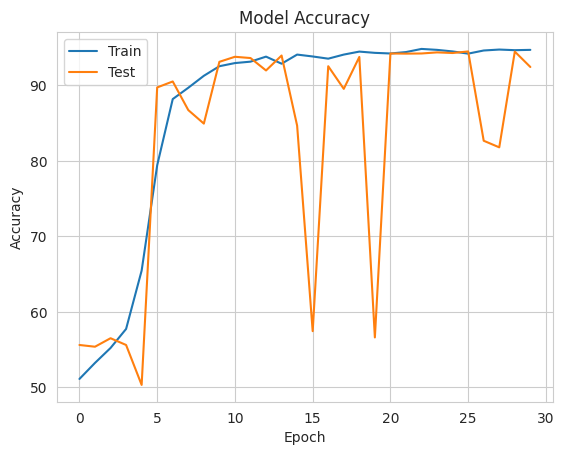

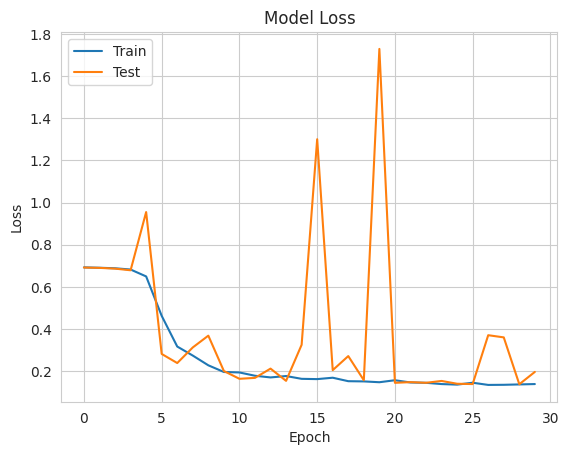

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from torch.utils.data import SubsetRandomSampler
from torch.optim import Adam
from tqdm import tqdm
from torch.utils.data import DataLoader 
import matplotlib.pyplot as plt


# sfk = StratifiedKFold(n_splits = config.FOLDS)
kfold = KFold(n_splits = config.FOLDS)
model_state_dicts = {}
 
for fold, (train_idx, val_idx) in enumerate(kfold.split(np.arange(len(dataset)))):
    
    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)
    
    train_loader = DataLoader(dataset, batch_size = config.BATCH_SIZE, sampler = train_sampler, collate_fn = MyCollate(0, config.MAX_LEN))
    val_loader = DataLoader(dataset, batch_size = config.BATCH_SIZE, sampler = val_sampler, collate_fn = MyCollate(0, config.MAX_LEN))  
    
    VOCAB_SIZE = len(dataset.source_vocab)
    HIDDEN_DIM = 128
    OUTPUT_DIM = 1
    VOCAB = list(dataset.source_vocab.stoi)

    embedding_layer = get_emb_layer_with_weights(target_vocab = VOCAB, emb_model = fasttext_model, trainable = False)

    model = Model(VOCAB_SIZE, config.EMB_DIM, HIDDEN_DIM, OUTPUT_DIM, embedding_layer)
    model = model.to(config.DEVICE)
    
#     model
#     model = Model(2, len(dataset.source_vocab), 128, 100, 1 ).to(config.DEVICE)
#     hidden = model.init_hidden(config.BATCH_SIZE)
#     model.hidden = hidden

    loss_fn = nn.BCELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)
    
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    print(f"-----------------------------------------------------------{fold}-fold of the model-----------------------------------------------------------")
    for epoch in range(config.EPOCHS):
        train_loss, train_correct = train_epochs(train_loader, model, loss_fn, optimizer)
        val_loss, val_correct = val_epochs(val_loader, model, loss_fn)  
        
        train_loss = train_loss/len(train_loader.sampler)
        val_loss = val_loss/len(val_loader.sampler)
        train_acc = (train_correct/len(train_loader.sampler))*100
        val_acc = (val_correct/len(val_loader.sampler))*100
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc.cpu().numpy().tolist())
        val_accs.append(val_acc.cpu().numpy().tolist())
        
        print(f"| Train Loss : {train_loss} |", end = " ")
        print(f" Val Loss : {val_loss} |", end = " ")
        print(f"Train Acc : {train_acc} |", end = " ")
        print(f"Val Acc : {val_acc} |")

        
    # Saving the state dicts for the model
    model_state_dicts.update({f"LSTM-Model-for-{fold}" : model.state_dict(),
                             f"Model-Optimizer-for-{fold}" : optimizer.state_dict()})
    
    # summarize history for accuracy
    plt.plot(train_accs)
    plt.plot(val_accs)
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(train_losses)
    plt.plot(val_losses)
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

In [ ]:
torch.save(model_state_dicts, "My-Model.pt")

In [ ]:
torch.save(model, 'model_torch.pt')

<h1  style="text-align: center" class="list-group-item list-group-item-action active">7. Inference</h1><a id = "7" ></a>

In [ ]:
def numericalize(text):
    
    numerialized_source = [] 
    numerialized_source = [dataset.source_vocab.stoi["<SOS>"]]
    numerialized_source += dataset.source_vocab.numericalize(text)
    numerialized_source.append(dataset.source_vocab.stoi["<EOS>"])
    
    return numerialized_source

def padding(source):
    padded_sequence = torch.zeros(config.MAX_LEN, 1, dtype = torch.int)
    source = torch.tensor(source)
    
    if len(source) > config.MAX_LEN:
        padded_sequence[:, 0] = source[: config.MAX_LEN]
    else:
        padded_sequence[:len(source), 0] = padded_sequence[:len(source), 0] + source
    
    return padded_sequence

In [ ]:
def infer_processing(text):
    
    text = preprocessing(text)
    text=" ".join(text);
    text = numericalize(text)
    text = padding(text)
    return text

In [ ]:
aspects = ["phone", "camera", "battery", "delivery", "processor"]

def get_similarity(text, aspect):
    try:
#         text = " ".join(text)
        return fasttext_model.wv.n_similarity(text, aspect)
    except:
        return 0
    
def best_aspect(text, aspects):
    a = []
    
    for aspect in aspects:
        a.append(get_similarity(text, aspect))
    
    return aspects[np.argmax(a)]


## VADER vs ABSA

In [ ]:
df_2 = df.head(50)
df_2 = df_2[['clean_review2', 'Sentence_Sentiment']]

In [ ]:
df_2.head()

,clean_review2,Sentence_Sentiment
0,great phone budget pubg performance rough came...,Negative
1,best smartphone mi range born r confuse samsun...,Negative
2,bad smooth phone back camera quality evil rear...,Negative
3,thise nice mobile like much delivery also fast...,Positive
4,meagerly dissatisfy thumb section r superb del...,Positive


In [ ]:
reviews = df_2['clean_review2'].to_list()

In [ ]:
sentiments = []
for review in reviews: 
  review=preprocessing(review)
  review=" ".join(review)
  best_asp = best_aspect(review, aspects)

  a = infer_processing(review).to(config.DEVICE)

  model.eval()
  sentiment = model(a)
  sentiment = sentiment.cpu().detach().numpy()[0]
  if sentiment[0] > 0.5:
    sentiment = 'positive'
  else:
    sentiment = 'negative'
  sentiments.append(sentiment)

In [ ]:
df_2['Aspect_Sentiment'] = sentiments

In [ ]:
df_2.head(10)

,clean_review2,Sentence_Sentiment,Aspect_Sentiment
0,great phone budget pubg performance rough came...,Negative,negative
1,best smartphone mi range born r confuse samsun...,Negative,negative
2,bad smooth phone back camera quality evil rear...,Negative,negative
3,thise nice mobile like much delivery also fast...,Positive,positive
4,meagerly dissatisfy thumb section r superb del...,Positive,negative
5,great product price segmentit delivers well pe...,Positive,positive
6,front camera awesome rear camera little bit go...,Positive,positive
7,love phone camera feature bought mother absolu...,Positive,positive
8,redmi note5 pro effortlessly set new standard ...,Positive,positive
9,nice mobile bettery first one half day good pe...,Negative,negative


In [ ]:
df_2.head()

,clean_review2,Sentence_Sentiment,Aspect_Sentiment
0,great phone budget pubg performance rough came...,Negative,negative
1,best smartphone mi range born r confuse samsun...,Negative,negative
2,bad smooth phone back camera quality evil rear...,Negative,negative
3,thise nice mobile like much delivery also fast...,Positive,positive
4,meagerly dissatisfy thumb section r superb del...,Positive,negative


## ABSA Sample Data

In [ ]:
sample_reviews_df = pd.read_csv('Sample_Reviews.csv')
sample_reviews_df.head()

,Review,Aspect,Sentiment
0,I am really impressed with the phone's great b...,Battery,positive
1,evil processor,processor,negative
2,amazing battery,battery,positive
3,best camera,camera,positive
4,worst phone,Phone,negative


In [ ]:
sample_reviews_sentiments = []
sample_reviews_aspects = []
sample_reviews = sample_reviews_df['Review'].to_list()

for review in sample_reviews:
  review=preprocessing(review)
  review=" ".join(review)
  best_asp = best_aspect(review, aspects)

  sample_reviews_aspects.append(best_asp)

  a = infer_processing(review).to(config.DEVICE)

  model.eval()
  sentiment = model(a)
  sentiment = sentiment.cpu().detach().numpy()[0]
  if sentiment[0] > 0.5:
    
    sentiment = 'positive'
  else:
    sentiment = 'negative'
  sample_reviews_sentiments.append(sentiment)

In [ ]:
sample_reviews_df['Predicted_Aspect'] = sample_reviews_aspects
sample_reviews_df['Predicted_Sentiment'] = sample_reviews_sentiments

In [ ]:
sample_reviews_df.head()

,Review,Aspect,Sentiment,Predicted_Aspect,Predicted_Sentiment
0,I am really impressed with the phone's great b...,Battery,positive,battery,positive
1,evil processor,processor,negative,processor,negative
2,amazing battery,battery,positive,battery,positive
3,best camera,camera,positive,camera,positive
4,worst phone,Phone,negative,phone,negative


In [ ]:
from sklearn.metrics import accuracy_score

actual_aspect = sample_reviews_df['Aspect'].to_list()
actual_aspect = [x.lower() for x in actual_aspect]
predicted_aspect = sample_reviews_df['Predicted_Aspect'].to_list()
predicted_aspect = [x.lower() for x in predicted_aspect]


# for i in range(50):
#   if actual_aspect[i] != predicted_aspect[i]:
#     print(i)

aspect_accuracy = accuracy_score(actual_aspect, predicted_aspect)
aspect_accuracy*100

72.0

In [ ]:
from sklearn.metrics import accuracy_score

actual_sentiment = sample_reviews_df['Sentiment'].to_list()
actual_sentiment = [x.lower() for x in actual_sentiment]
predicted_sentiment = sample_reviews_df['Predicted_Sentiment'].to_list()
predicted_sentiment = [x.lower() for x in predicted_sentiment]

sentiment_accuracy = accuracy_score(actual_sentiment, predicted_sentiment)
sentiment_accuracy*100

82.0

## ABSA on Weekly Reviews


In [ ]:
def get_senitment_scores(reviews):

  sentiments = []
  scores_sum = {}
  scores_count = {}
  scores_actual = {}

  for review in reviews: 
    review=preprocessing(review)
    review=" ".join(review)
    best_asp = best_aspect(review, aspects)

    a = infer_processing(review).to(config.DEVICE)

    model.eval()
    sentiment = model(a)
    sentiment = sentiment.cpu().detach().numpy()[0]
    sentiments.append((best_asp, sentiment[0]))

  for a in aspects: 
    scores_sum[a] = 0
    scores_count[a] = 0
    scores_actual[a] = 0

  for i in range(len(sentiments)):
    scores_sum[sentiments[i][0]] += sentiments[i][1]
    scores_count[sentiments[i][0]] += 1

  for a in aspects:
    if scores_count[a]!=0:
      scores_actual[a]=int((scores_sum[a]*100)/scores_count[a])

  return scores_actual, scores_count


In [ ]:
scores_actual_df = pd.DataFrame(columns = aspects)
scores_count_df = pd.DataFrame(columns = aspects)

In [ ]:
Week_1_reviews = ["I am really impressed with the phone's great battery backup.", "evil processor", "amazing battery", "great camera", "worst" ,"battery is impressive"]
Week_2_reviews = ["The battery on the phone is bad","bad camera","Processor is very bad","Good","amazing phone","okay phone"]
Week_3_reviews = ['Camera is very bad', 'Quality of camera is bad', 'okay okay', 'bad phone', 'very good phone', 'amazing battery', 'good delivery features']
Week_4_reviews = ["Amazing camera", " Very good camera", "Battery is good", "Very Good phone", "very poor camera", "Amazing service","Processor Bad"]
Week_5_reviews = ['processor is slow', 'need to update battery life', 'good customer care', 'amazing life with this phone']

In [ ]:
reviews_list = [Week_1_reviews, Week_2_reviews, Week_3_reviews, Week_4_reviews, Week_5_reviews]

In [ ]:
for i in range(len(reviews_list)): 
  scores,counts = get_senitment_scores(reviews_list[i])
  scores_actual_df = scores_actual_df.append(scores, ignore_index=True)
  scores_count_df = scores_count_df.append(counts, ignore_index=True)

<ipython-input-361-aca09dc62a3e>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_actual_df = scores_actual_df.append(scores, ignore_index=True)
<ipython-input-361-aca09dc62a3e>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_count_df = scores_count_df.append(counts, ignore_index=True)
<ipython-input-361-aca09dc62a3e>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_actual_df = scores_actual_df.append(scores, ignore_index=True)
<ipython-input-361-aca09dc62a3e>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_count_df = scores_count_df.append(counts, ignore_index=True)
<ipython-input-361-aca09dc62a3e>:3: Futu

In [ ]:
scores_count_df.head()

,phone,camera,battery,delivery,processor
0,0,1,3,0,2
1,3,1,0,0,2
2,2,1,3,0,1
3,1,2,0,0,4
4,1,0,0,1,2


In [ ]:
scores_actual_df.head()

,phone,camera,battery,delivery,processor
0,0,91,91,0,3
1,71,4,0,0,61
2,49,24,72,0,90
3,97,89,0,0,78
4,91,0,0,94,74


In [ ]:
scores_actual_df.head()

,phone,camera,battery,delivery,processor
0,0,91,91,0,3
1,71,4,0,0,61
2,49,24,72,0,90
3,97,89,0,0,78
4,91,0,0,94,74


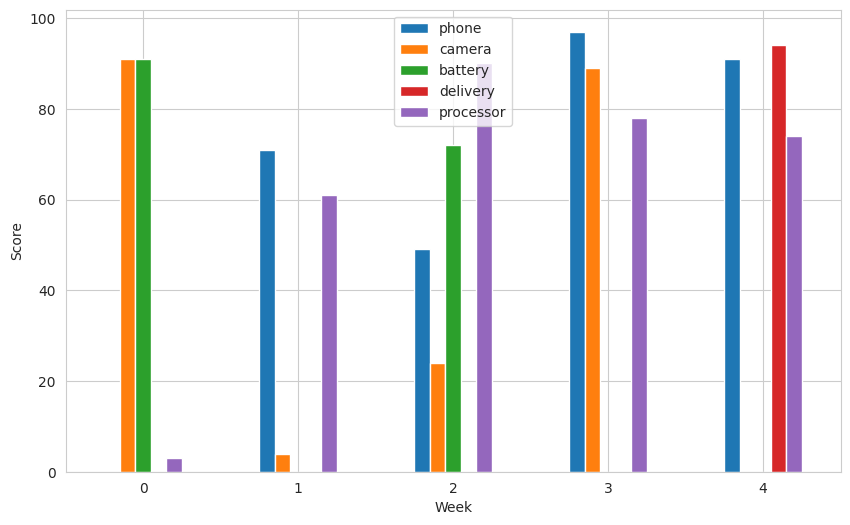

In [ ]:
ax = scores_actual_df.plot(kind='bar', rot=0, figsize = (10, 6))
ax.set_xlabel("Week")
ax.set_ylabel("Score")
ax.figure.savefig("week_plot.png")

In [ ]:
week = scores_actual_df.shape[0]
def plot_graph():
  for a in aspects:

    plot_scores = [50]

    avg_scores = scores_actual_df[a].tolist()
    avg_counts = scores_count_df[a].tolist()

    print(avg_scores, avg_counts)

    reviews_sum = 50
    total_reviews = 1

    for i in range(week):
      total_reviews += avg_counts[i]
      reviews_sum += (avg_scores[i] * avg_counts[i])
      
      plot_scores.append(int((reviews_sum)/(total_reviews)))

    plt.plot(plot_scores)
    plt.ylim(0,100)
    plt.xticks([0, 1, 2, 3, 4])

    plt.title(a)
    plt.xlabel("Score")
    plt.ylabel("Week")

    plt.savefig(f'{a}_plot.png')
    plt.show()

[0, 71, 49, 97, 91] [0, 3, 2, 1, 1]


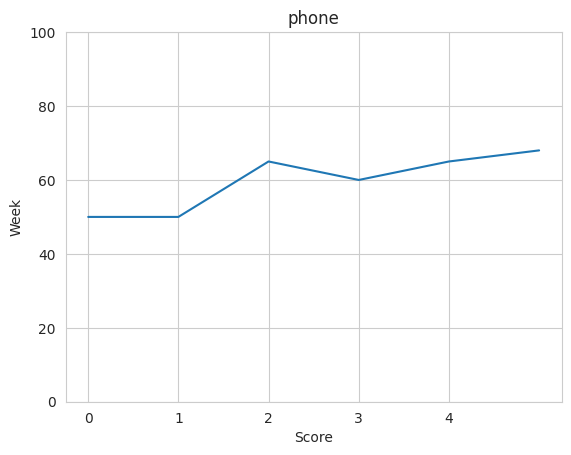

[91, 4, 24, 89, 0] [1, 1, 1, 2, 0]


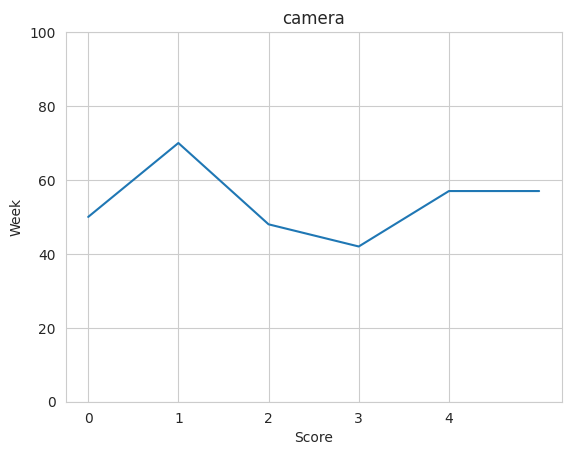

[91, 0, 72, 0, 0] [3, 0, 3, 0, 0]


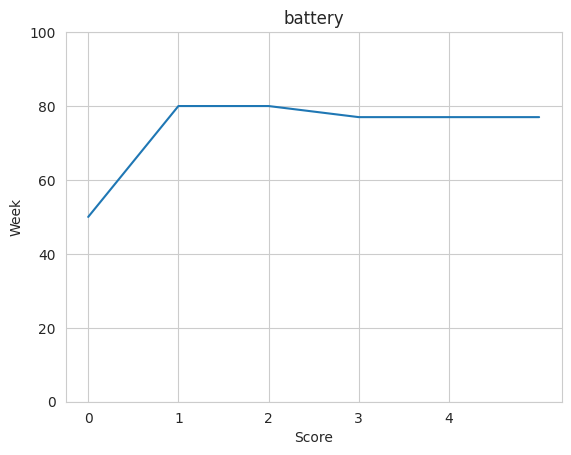

[0, 0, 0, 0, 94] [0, 0, 0, 0, 1]


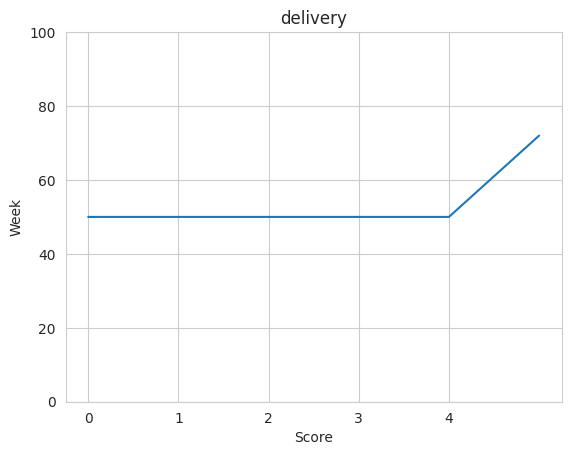

[3, 61, 90, 78, 74] [2, 2, 1, 4, 2]


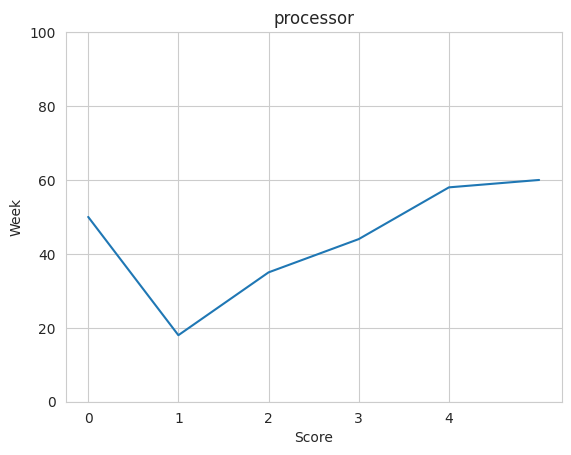

In [ ]:
plot_graph()